In [10]:
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph
import collections
import matplotlib.pyplot as plt
import seaborn as sns

In [141]:
#from cdlib import evaluation

n = 100000
tau1 = 3 # 2-3
tau2 = 1.5 # 1-2
mu = 0.1

def create_benchmark_graph(n, tau1, tau2, mu, average_degree, min_community, seed):
    count = 0
    num_tries = 5
    while count < num_tries:
        try:
            G = LFR_benchmark_graph(
                n, tau1, tau2, mu, average_degree=average_degree, \
                    min_community=min_community
            )
            return G
        except Exception as e: 
            print(e)
            count +=1 


In [322]:
create_benchmark_graph(20000,3,1.5,0.1,6,40,'') #6,10,14,18,22

In [323]:
configuration = {
    #'n':[500,1581,5000,15811,50000],#, 50000, 100000],
    'n':[20000],
    #'n':[500,1000],
    #'n':[10000],
    'tau1': [3],
    'tau2': [1.5],
    #'mu': [0.05,0.1,0.2,0.3,0.4,0.5],
    'mu': [0.1],
    'avg_degree': [6,10,14,18,22]
    #'avg_degree': [4,6,8]
}

In [324]:

configurations_possible = []

def get_possible_configs(conf, index, current):

    if index == len(conf):
        configurations_possible.append(current.copy())
        print(current)
        return 

    here = list(conf.keys())[index]

    for value in conf[here]:
        current[here] = value
        get_possible_configs(conf, index + 1, current)


get_possible_configs(configuration, 0, {})


{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 6}
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 10}
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 14}
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 18}
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 22}


In [14]:
from collections import defaultdict
import community.community_louvain as community_louvain
import math
#from cdlib import algorithms
#import cdlib

def get_communities(G):

    communities = {frozenset(G.nodes[v]["community"]) for v in G}


    # (com_nr, set community)
    lrf_dict = defaultdict()
    c = 1
    for y in communities:
        lrf_dict[c] = y
        c+= 1


    # (comm_nr, set communities)
    partion = community_louvain.best_partition(G)
    louvain_dict = defaultdict(set)





    for node, community in partion.items():
        louvain_dict[community].add(node) # (community_nr, nodes)

    #x1 = cdlib.NodeClustering(list(louvain_dict.values()), G)
    #x2 = cdlib.NodeClustering(list(lrf_dict.values()), G)

    #print(evaluation.normalized_mutual_information(x1, x2))


    return lrf_dict, louvain_dict



def get_percentage_intercetion(set_ids, mapping_ids):

    z = set()
    for id in set_ids:
        z = z.union(mapping_ids[id])
    return z


def is_small_community(G, community):
    res_limit_val = math.sqrt(2*G.number_of_edges())
    sub = G.subgraph(community)
    return sub.number_of_edges() < res_limit_val



def compare_communities_stats(G):

    lrf_dict, louvain_dict = get_communities(G)

    assigned_ones = defaultdict(set)# sets from the louvain that are assigned as most similar to the same set of the lrf

    for k, y in lrf_dict.items():
        
        higher = -1
        target_set = set() # set with the most common nodes
        overlapping_set_nr = set()

        for nr, com_set in louvain_dict.items():

            temp = com_set & y
            
            if len(temp) > 0:
                overlapping_set_nr.add(nr)
                assigned_ones[nr].add(k)

            
            if higher < len(temp):
                higher = len(temp)

        louvain_union = get_percentage_intercetion(overlapping_set_nr, louvain_dict)
        lrf_union = lrf_dict[k]
        percentage = len(louvain_union.intersection(lrf_union)) / max(len(louvain_union), len(lrf_union))
        #print("For lrf community with size {}, there were found in louvain {} communities overlapping".format(len(y), len(overlapping_set_nr)))
        #print("For lrf community id {} (resol_lim : {}), they intersect with louvain communities ids {} => {}".format(k,\
        #is_small_community(G, lrf_union) ,overlapping_set_nr, percentage))

    THRESHOLD = 0.9
    counter = 0
    total = 0
    print("the other way around:")
    for k, y in assigned_ones.items(): 
        temp = []
        # k -> community id of louvain
        # y -> set of communities id of lrf
        # community id of louvain -> communties of lrf that overlap with the louvain
        louvain_union = louvain_dict[k]
        lrf_union = get_percentage_intercetion(y, lrf_dict)
        percentage = len(louvain_union.intersection(lrf_union)) / max(len(louvain_union), len(lrf_union))
        #print("{} (louvain (resol_lim : {})) : {} (lrf) => {}" .format(k, is_small_community(G, louvain_union), y, percentage))

        for v in y:
            if len(lrf_dict[v] & louvain_union) / len(lrf_dict[v]) >= THRESHOLD:
                temp.append(v)
                total +=1
        
        if len(temp) > 1:
            #print(k, "=>", len(temp))
            counter += len(temp) #- 1
            #print(v, len(lrf_dict[v] & louvain_union) / len(lrf_dict[v]) )

    #print("counter total", counter, "|", len(lrf_dict), "|", counter/ len(lrf_dict))
    print("counter2 total", counter, "|", total, "|", counter/total)
    return counter/total

def compare_communities_number(G):
    partion = community_louvain.best_partition(G)
    l_c = max(partion.values())

    communities = {frozenset(G.nodes[v]["community"]) for v in G}
    lrf_c = len(communities)

    return l_c , lrf_c

#algorithms.louvain(nx.karate_club_graph())

In [6]:
def community_size_distribution(G):
    lrf_dict, louvain_dict = get_communities(G)
    counter=collections.Counter([G.subgraph(x).number_of_edges() for x in lrf_dict.values()])
    counter2=collections.Counter([G.subgraph(x).number_of_edges() for x in louvain_dict.values()])
    res_limit_val = math.sqrt(G.number_of_edges()/2)
    plt.figure(figsize=(6,6))
    plt.style.use('seaborn-whitegrid')
    plt.hist(counter,bins=20,alpha=0.7, label='x')
    plt.hist(counter2,bins=20,alpha=0.7, label='y')
    plt.axvline(x=res_limit_val, color= 'r')
    plt.legend(loc='upper right')
    plt.show()

In [161]:
def run_experiment(configurations_possible, experiment_call_back):

    values = []
    for configuration in configurations_possible:
        print(configuration)
        G = create_benchmark_graph(configuration['n'], configuration['tau1'], \
            configuration['tau2'], configuration['mu'], \
            average_degree=configuration['avg_degree'], min_community=40, seed=10)
        values.append(experiment_call_back(G))
        #print(values)
    
    #print(values)
    return values

In [ ]:
run_experiment(configurations_possible, compare_communities_number)

In [ ]:
run_experiment(configurations_possible, compare_communities_stats)

In [ ]:
run_experiment(configurations_possible, community_size_distribution)


In [273]:
import numpy as np
from os.path import exists

def total_results(times,experiment_callback,path):
    if exists(path):
        results = np.load(path).tolist()
    else:
        results = []
    #print(len(results))
    i = 0
    while i < times:
        try:
            res = run_experiment(configurations_possible, experiment_callback)
            for j in range(len(res)):
                if len(results) <= j:
                    results.append([res[j]])
                else:
                    results[j].append(res[j])
            np.save(path,results)
            i+=1
        except Exception as e: 
            print(e)
    return results


In [206]:
import scipy.stats as st
def get_intervals(res):
    intervals = []
    for data in res:
        if np.all(data == data[0]):
            intervals.append((data[0],data[0]))
        else:
            intervals.append(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)))
    #intervals = [st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) for data in res]
    return intervals


In [351]:
res = total_results(times = 20,experiment_callback = compare_communities_stats,path='mu.npy')

{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 6}
Could not assign communities; try increasing min_community
Could not create power law sequence
the other way around:
counter2 total 90 | 164 | 0.5487804878048781
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 10}
the other way around:
counter2 total 47 | 122 | 0.38524590163934425
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 14}
Could not assign communities; try increasing min_community
the other way around:
counter2 total 6 | 50 | 0.12
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 18}
the other way around:
counter2 total 26 | 126 | 0.20634920634920634
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 22}
the other way around:
counter2 total 9 | 106 | 0.08490566037735849
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 6}
the other way around:
counter2 total 166 | 235 | 0.7063829787234043
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 1

KeyboardInterrupt: 

In [343]:
def show_plot(x_values,intervals,mixing_param,title,metric= 'CCR',x_log = False):
    y = [(x[0]+x[1])/2 for x in intervals]
    yerr = [(x[1]-x[0]) for x in intervals]
    plt.figure(figsize=(6,6))
    plt.errorbar(x_values, y, yerr=yerr, fmt='o--')
    plt.style.use('seaborn-whitegrid')
    if x_log:
        plt.xscale('log')
    plt.title(title)
    plt.xlabel(mixing_param)
    plt.ylabel(metric)
    plt.ylim(0)
    plt.show()


(5, 20)


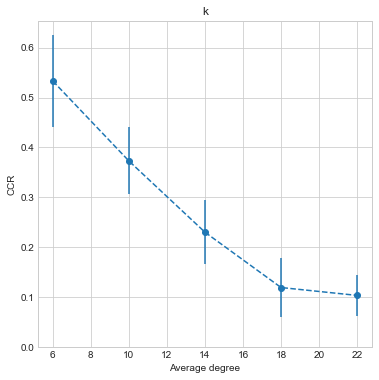

In [352]:
res_degree = np.load('average_degree.npy')
print(res_degree.shape)
intervals_degree = get_intervals(res_degree)
show_plot([6,10,14,18,22],intervals_degree,'Average degree','k')

(5, 20)


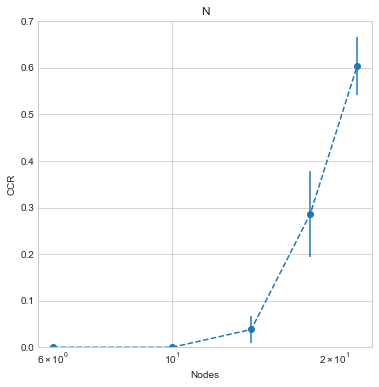

In [339]:
res_nodes = np.load('nodes.npy')
print(res_nodes.shape)
intervals_nodes = get_intervals(res_nodes)
show_plot([500,1581,5000,15811,50000],intervals_nodes,'Nodes','N',x_log=True)